# Reading CTD data with PySeabird

## Author: Guilherme Castelão

pySeabird is a package to parse/load CTD data files. It should be an easy task but the problem is that the format have been changing along the time. Work with multiple ships/cruises data requires first to understand each file, to normalize it into a common format for only than start your analysis. That can still be done with few general regular expression rules, but I would rather use strict rules. If I'm loading hundreds or thousands of profiles, I want to be sure that no mistake passed by. I rather ignore a file in doubt and warn it, than belive that it was loaded right and be part of my analysis.

With that in mind, I wrote this package with the ability to load multiple rules, so new rules can be added without change the main engine.

For more information, check the documentatio

In [1]:
%matplotlib inline

from seabird.cnv import fCNV

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


Let's first download an example file with some CTD data

In [2]:
!wget https://raw.githubusercontent.com/castelao/seabird/master/sampledata/CTD/dPIRX003.cnv

--2018-08-01 11:57:44--  https://raw.githubusercontent.com/castelao/seabird/master/sampledata/CTD/dPIRX003.cnv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.136.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.136.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47291 (46K) [text/plain]
Saving to: ‘dPIRX003.cnv.12’

dPIRX003.cnv.12     100%[===================>]  46.18K  --.-KB/s    in 0.01s   

2018-08-01 11:57:44 (4.26 MB/s) - ‘dPIRX003.cnv.12’ saved [47291/47291]



In [3]:
profile = fCNV('dPIRX003.cnv')

DEBUG:root:Openning file: dPIRX003.cnv


The profile dPIRX003.cnv.OK was loaded with the default rule cnv.yaml

### The header (metadata)

The header is loaded into the .attributes as a dictionary. Note that the date was already converted into a datetime object.

There is a new attribute, not found in the file, that is 'md5'. This is the MD5 Hash for the original file. This might be usefull to double check the inputs when reproducing some analysis.

Since it's a dictionary, to extract the geographical coordinates, for example:

In [4]:
print ("The profile coordinates is latitude: %.4f, and longitude: %.4f" % \
    (profile.attributes['LATITUDE'], profile.attributes['LONGITUDE']))

The profile coordinates is latitude: 12.6743, and longitude: -38.0018


Or for an overview of all the attributes and data:

In [5]:
print("Header: %s" % profile.attributes.keys())
print(profile.attributes)

Header: dict_keys(['sbe_model', 'seasave', 'instrument_type', 'nquan', 'nvalues', 'start_time', 'bad_flag', 'file_type', 'md5', 'datetime', 'LATITUDE', 'LONGITUDE', 'filename'])
{'sbe_model': '9', 'seasave': 'Win32 V 5.37d', 'instrument_type': 'CTD', 'nquan': '11', 'nvalues': '349', 'start_time': 'Apr 02 2008 18:52:30', 'bad_flag': '-9.990e-29', 'file_type': 'ascii', 'md5': '1ad70243bdea4bfd4c6f60ca7141bf2b', 'datetime': datetime.datetime(2008, 4, 2, 18, 52, 30), 'LATITUDE': 12.674333333333333, 'LONGITUDE': -38.00183333333333, 'filename': 'dPIRX003.cnv'}


### The data

The object profile behaves like a dictionary with the data. So to check the available data one can just

In [6]:
print(profile.keys())

['timeS', 'PRES', 'TEMP', 'TEMP2', 'CNDC', 'CNDC2', 'potemperature', 'potemperature2', 'PSAL', 'PSAL2', 'flag']


Each data returns as a masked array, hence all values equal to profile.attributes['bad_flag'] will return as a masked value

In [7]:
profile['TEMP2'][:25]

masked_array(data = [15.7969 15.5144 15.4179 15.3232 15.1983 15.1154 15.076 15.0842 15.0535
 15.0212 14.9611 14.8273 14.7881 14.7453 14.7223 14.7371 14.7438 14.7413
 14.7404 -- 14.4535 14.3612 14.2561 14.2155 14.2098],
             mask = [False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False],
       fill_value = -9.99e-29)

As a regular masked array, let's check the mean and standard deviation between the two temperature sensors

In [8]:
print(profile['TEMP'].mean(), profile['TEMP'].std())
print(profile['TEMP2'].mean(), profile['TEMP2'].std())

11.5807006135 1.5675053881
11.5404211009 1.61107230384


Text(0.5,1,'dPIRX003.cnv')

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/doppler/anaconda3/envs/main/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/doppler/anaconda3/envs/main/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


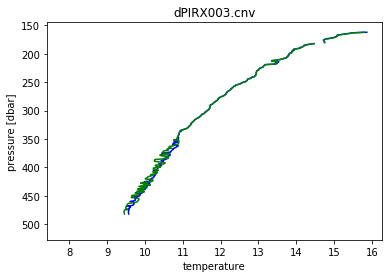

In [9]:
from matplotlib import pyplot as plt

plt.plot(profile['TEMP'], profile['PRES'],'b')
plt.plot(profile['TEMP2'], profile['PRES'],'g')
plt.gca().invert_yaxis()
plt.xlabel('temperature')
plt.ylabel('pressure [dbar]')
plt.title(profile.attributes['filename'])

We can also export the data into a [pandas](http://pandas.pydata.org) DataFrame for easier data manipulation later on:

In [10]:
df = profile.as_DataFrame()
df.head()

,timeS,PRES,TEMP,TEMP2,CNDC,CNDC2,potemperature,potemperature2,PSAL,PSAL2,flag,LATITUDE,LONGITUDE
0,246.446,162.0,15.8635,15.7969,4.468541,4.497739,15.8372,15.7713,35.7561,36.0788,0.0,12.674333,-38.001833
1,249.417,163.0,15.4798,15.5144,4.459094,4.460689,15.4545,15.4889,36.0197,36.0024,0.0,12.674333,-38.001833
2,250.462,164.0,15.3983,15.4179,4.444983,4.448821,15.3729,15.3924,35.9660,35.9829,0.0,12.674333,-38.001833
3,251.428,165.0,15.2930,15.3232,4.432046,4.436992,15.2675,15.2977,35.9446,35.9618,0.0,12.674333,-38.001833
4,252.285,166.0,15.1721,15.1983,4.417620,4.422013,15.1466,15.1728,35.9237,35.9397,0.0,12.674333,-38.001833
